In [1]:
%matplotlib inline
%load_ext rpy2.ipython

In [2]:
%%R
# loading R packages
library(DESeq2)
library(phyloseq)
library(plyr)
library(dplyr)
#dplyr needs to come in last
library(ggplot2)
library(doParallel)
library(rwantshue)
library(RColorBrewer)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, intersect,
    is.unsorted, lapply, Map, mapply, match, mget, order, paste, pmax,
    pmax.int, pmin, pmin.int, Position, rank, rbind, Reduce, rep.int,
    rownames, sapply, setdiff, sort, table, tapply, union, unique,
    unlist, unsplit

Loading required package: IRanges
Loading required package: GenomicRanges
Loading required package:

In [3]:
%%R
physeq = import_biom("../../SeqData/otu_table.tax.meta.biom", "../../SeqData/trees/fulltree.tre", parseFunction = parse_taxonomy_greengenes)

In [251]:
%%R
#sample_data(physeq)$TrtmtDay = paste(sample_data(physeq)$Trtmt,sample_data(physeq)$Day,sep="")
d = data.frame(sample_data(physeq)) %>%
    arrange(Cosm)
d

   Cosm Trtmt Day TrtmtDay
1    18     X   1       X1
2    18     X   0       X0
3    18     X   7       X7
4    18     X   5       X5
5    18     X   2       X2
6    18     X   3       X3
7     2     N   2       N2
8     2     N   5       N5
9     2     N   3       N3
10    2     N   7       N7
11    2     N   1       N1
12    2     N   0       N0
13   23     N   7       N7
14   23     N   0       N0
15   23     N   2       N2
16   23     N   5       N5
17   23     N   1       N1
18   23     N   3       N3
19   25     X   5       X5
20   25     X   1       X1
21   25     X   2       X2
22   25     X   7       X7
23   25     X   3       X3
24   25     X   0       X0
25   27     N   2       N2
26   27     N   0       N0
27   27     N   1       N1
28   27     N   2       N2
29   27     N   3       N3
30   27     N   5       N5
31   27     N   5       N5
32   27     N   7       N7
33   27     N   3       N3
34   27     N   7       N7
35   30     X   1       X1
36   30     X   7       X7
3

In [4]:
%%R
sample.data<-data.frame(sample_data(physeq)) %>%
    dplyr::group_by(Trtmt,Day) %>%
    dplyr::summarize(total=n())
sample.data
# Find out how many of each treatment-month combination we have... 
# Don't want to run it on anything with just one or two samples

Source: local data frame [12 x 3]
Groups: Trtmt

   Trtmt Day total
1      N   0     6
2      N   1     6
3      N   2     6
4      N   3     6
5      N   5     6
6      N   7     6
7      X   0     6
8      X   1     6
9      X   2     6
10     X   3     6
11     X   5     6
12     X   7     6


In [256]:
%%R
# Creating a matrix with the different combinations of variables for day and amendment
#variables = expand.grid(Trtmt = c("X","N"), Day = c(0,1,2,3,5,7))
variables = levels(as.factor(sample_data(physeq)$TrtmtDay))
variables = variables[variables!="X0"]
variables

 [1] "N0" "N1" "N2" "N3" "N5" "N7" "X1" "X2" "X3" "X5" "X7"


There are a couple of possible comparisons:  
X vs N at each timepoint  
Each timepoint vs 0 bulk soil timepoint  
For bulk the timepoint approach makes sense, but for N, not quite...  
Start with all samples vs. bulk X trtmt

In [232]:
%%R
sample_data(physeq)$Cosm = as.factor(sample_data(physeq)$Cosm)
class(sample_data(physeq)$Cosm)

[1] "factor"


In [255]:
%%R
#run deseq on each subset of factors (day and amendment), return the factors, OTU ID, base mean, log2-fold change, 
# the standard error, and the p value associated with the response.

Dif_Abund = function(TrtmtDay){
    physeq.pruned <- prune_samples(((sample_data(physeq)$TrtmtDay == TrtmtDay) | (sample_data(physeq)$TrtmtDay == "X0")),physeq)
    taxonomy <- data.frame(tax_table(physeq.pruned))
    sampledata = data.frame(sample_data(physeq.pruned))
    dseq = phyloseq_to_deseq2(physeq.pruned, ~ TrtmtDay)
    dseq$TrtmtDay = relevel(dseq$TrtmtDay,"X0")
    dseq = DESeq(dseq, quiet = TRUE, fitType = "local")
    results = results(dseq, cooksCutoff=TRUE)
# Change Cooks Cutoff to control outliers or not
    results$TrtmtDay = TrtmtDay
    results = data.frame(results$TrtmtDay,rownames(results),results$baseMean,results$log2FoldChange,results$lfcSE,results$pvalue,taxonomy[,1:7])
    colnames(results) = c("TrtmtDay","OTU","baseMean","l2FC","SE","pvalue","Kingdom","Phylum","Class","Order","Family","Genus","Species")
    results
    }
# Note: this function throws an error based on calculating the geometric mean for samples with very low OTU counts
# Thus, we added the prune_samples step above, removing any samples with fewer than X counts.

In [257]:
%%R
# Joining the variables and the differential abundance
DA<-mdply(variables,Dif_Abund)

# Runs the  differential abundance function we created above on all the timepoints and N treatments

converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode


In [258]:
%%R
threshold = function (thresh){
    dplyr::filter(DA, baseMean >= thresh) %>% 
    dplyr::mutate(padj = p.adjust(pvalue,"BH")) %>%
    dplyr::summarize(cutoff=thresh, count=sum(padj<=0.10, na.rm = TRUE))
}
# Takes our table of differential abundance values,
# and determines those for which the baseMean values is greater or equal to whatever we input as threshould
# Then, for any samples that meet that criterion, we add a column (mutate), where we adjust the p value 
# using the Benjamini & Hochberg correction
# Then we summarize the results, listiing the cutoff threshold, and then the total number of OTUs for which the 
# new adjusted p values is less than 0.10 (just a standard level used by others).
# Note we also specify that the functions are called using dplyr package ("dplyr::").

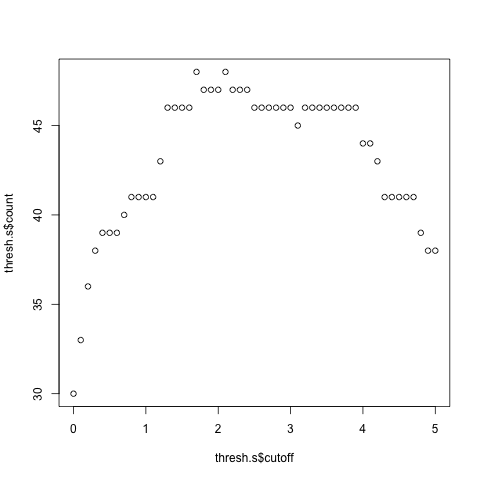

In [259]:
%%R
range = seq(0,5,0.1)
# Creates a range of numbers we are interested in for adjusted p values
thresh.s <- ldply(range, threshold)
# Applys the Threshold function we created above to the range of numbers we created above.

plot(thresh.s$count~thresh.s$cutoff)
# We can plot the threshold for base Mean value against the number of samples that will pass under this cutoff.
# We can see the optimum value to use here (here, 1.7)

In [260]:
%%R
group_by(DA, TrtmtDay) %>%
    mutate(Total=sum(baseMean)) %>%
    filter(baseMean>=2) %>% 
    mutate(padj = p.adjust(pvalue,"BH")) %>% 
    write.csv("../../SeqData/l2fc.csv", row.names=FALSE)
# We take that differential abundance table we created above, and filter it to include only those samples 
# that had a baseMean value above the optimal cutoff we determined above.
# We then adjust the p values and save it as a csv.

In [261]:
%%R
l2fc<-read.csv("../../SeqData/l2fc.csv")

In [262]:
%%R
dim(l2fc[is.na(l2fc$padj)==TRUE,])/(dim(l2fc[is.na(l2fc$padj)==FALSE,])+dim(l2fc[is.na(l2fc$padj)==TRUE,]))
# Fraction of OTUs that were designated as "outliers" 

[1] 0.003324689 0.500000000


In [263]:
%%R

cutoff = 1
FDR = 0.1

d = l2fc %>%
    group_by(TrtmtDay)%>%
    mutate(Sig = ifelse(padj<FDR&l2FC>=cutoff,1,0))%>%
    mutate(Sig = ifelse(is.na(padj)==TRUE,0,Sig))%>%
    group_by(TrtmtDay)%>%
    count(TrtmtDay,Sig)%>%
    group_by(TrtmtDay)%>%
    mutate(Fraction=n/sum(n))
mean(d$Fraction[d$Sig==1])

[1] 0.002271868


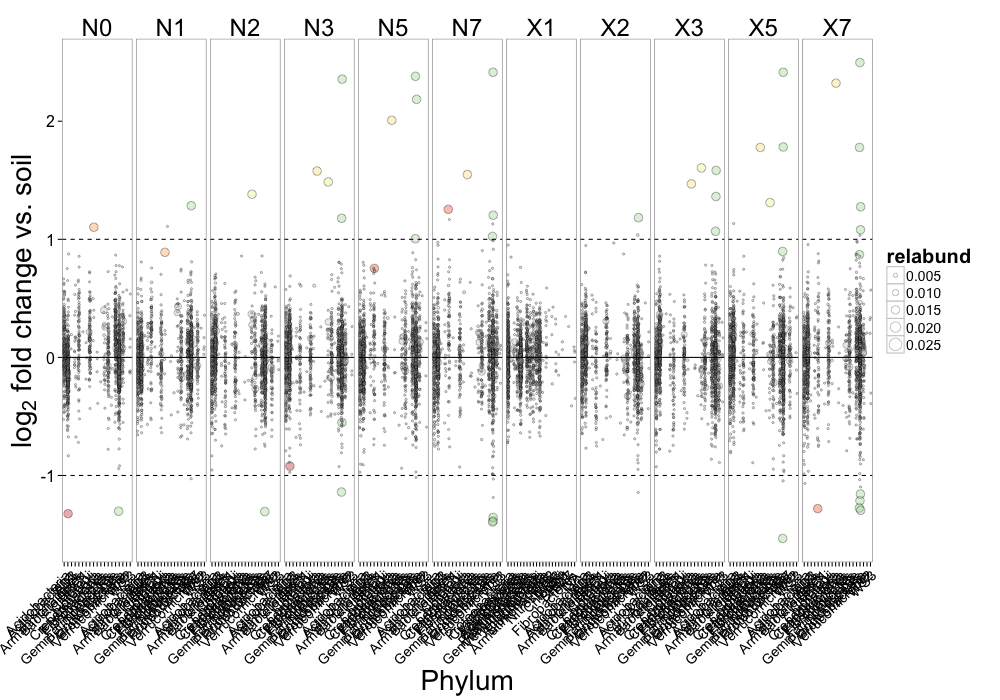

In [273]:
%%R -w 1000 -h 700
# setting the image sizes, then making the figure...

d = l2fc
FDR = 0.1

d = d %>%
    group_by(TrtmtDay) %>%
    mutate(sig = ifelse(padj<=FDR,1,0))%>%
    mutate(relabund=baseMean/Total)%>%
    filter(pvalue != 'NA')
# This compares it to the whole sample, not just the signficantly increased subset in l2fc
    
max.l2FC = ddply(d, .(Phylum), summarize, M = max(l2FC))
# makes a dataframe with the maximum value of log2Fold change for each phylum
d$Phylum = factor(d$Phylum, max.l2FC[order(-max.l2FC$M),]$Phylum)
# takes our phylum column, and arranges it in order of our log2FoldChange values
    
p = ggplot(d, aes(x = Phylum, y = l2FC, fill = Phylum))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being based on our "yes" or "no" column in the d data table.

p = p + facet_grid(~TrtmtDay, scales="free_x")
# saying we want it to present the data separately for our two variables (trtmt and month), in 2 columns

d$sig = as.factor(d$sig)
    
d.yes = d[d$sig==1,]
d.no = d[d$sig==0,]
    
p = p + geom_point(data=d.yes, aes(x = Phylum, y = l2FC, fill = Phylum), shape = 21, size=4, alpha=0.4, position = position_jitter(w = 0.20))
p = p + geom_point(data=d.no, aes(x = Phylum, y = l2FC, fill = sig, size=relabund), shape = 21, alpha=0.3, position = position_jitter(w = 0.20))

p = p + geom_hline(y = 1, linetype=2)
p = p + geom_hline(y = -1, linetype=2)
p = p + geom_hline(y = 0.0, linetype=1)
# puts in horizontal lines at reference values

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 24),
              strip.text.y = element_text(size = 24),
              axis.text.x = element_text(size = 14, angle = 45, hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 28),
              axis.text.y = element_text(size=16),
              axis.title.y = element_text(size = 28),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "Phylum")
# sets the label for the x axis. I think they didn't get the different colours.

p = p + labs(y = expression(paste("", log[2]," fold change vs. soil",sep="")))
# sets the label for the y axes.
    
colourCount = 8
getPalette = colorRampPalette(brewer.pal(8, "Spectral"))
p = p + scale_fill_manual(guide="none", values=c("grey",paste(getPalette(colourCount))))


#p = p + scale_color_continuous(trans="log")    
#p = p + scale_fill_discrete(guide="none")


p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines

    
# Would be cool to colour this by relative abundance in soil to begin with.. what drives patterns more?
    
p

In [57]:
%%R
ggsave(filename="DiffAbund16STrtmtDay.jpg", plot=p ,width=11.5, height=8)

In [23]:
%%R
ggsave(filename="DA16SResponders.jpg", p, width=7.5, height=6.75)

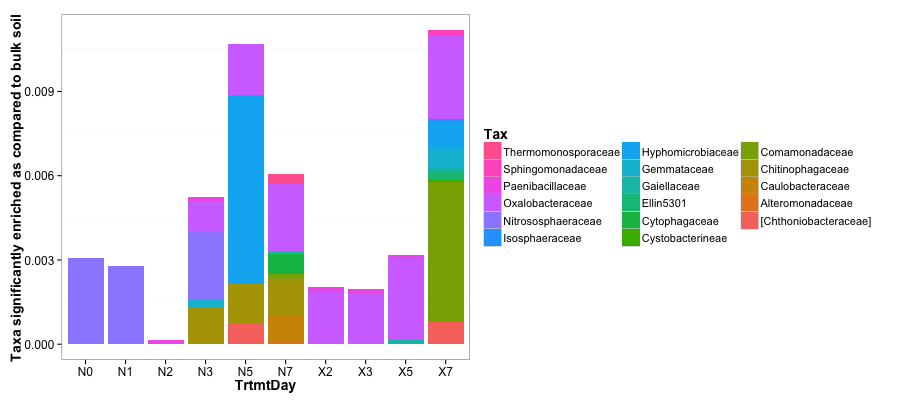

In [280]:
%%R -w 900 -h 400

FDR=0.5
cutoff = 0

d = l2fc %>%
    filter(padj<=FDR)%>%
    filter(l2FC>cutoff)%>%
    filter(Family!="mitochondria")%>%
    filter(Class!="Chloroplast")%>%
    mutate(Tax=Family)%>%
    mutate(Relabund=baseMean/Total)%>%
    group_by(TrtmtDay,Tax)%>%
    summarize(RelabundTot=sum(Relabund))

p = ggplot(d, aes(x=TrtmtDay, y=RelabundTot, fill = Tax))

p = p + geom_bar(stat = "identity", width = 0.90)

p = p + guides(fill = guide_legend(title="Tax", ncol = 3, reverse=TRUE))

p = p + xlab("TrtmtDay") + ylab("Taxa significantly enriched as compared to bulk soil")

p = p + theme_bw()

p = p + theme(axis.title = element_text(size=14,face="bold"))
p = p + theme(axis.text = element_text(size=12,))
p = p + theme(legend.text=element_text(size=11), legend.title=element_text(size=14), legend.position="right")
p = p + theme(strip.background = element_blank(),strip.text = element_text(size=14), panel.grid.major= element_blank())

p

In [278]:
%%R
FDR = 0.1
d = l2fc %>%
    filter(TrtmtDay=="N0")%>%
    filter(padj<=FDR)
#    filter(Phylum=="Crenarchaeota")
d

  X1 TrtmtDay           OTU baseMean      l2FC        SE       pvalue  Kingdom
1  1       N0  16SW107_4087  9.99949 -1.303638 0.2940674 9.287680e-06 Bacteria
2  1       N0   16SW57_4085 97.71538  1.098346 0.1995708 3.722433e-08  Archaea
3  1       N0 16SW81_634253 14.16601 -1.325573 0.2677714 7.406477e-07 Bacteria
          Phylum               Class             Order             Family
1 Proteobacteria Deltaproteobacteria      Myxococcales               <NA>
2  Crenarchaeota      Thaumarchaeota Nitrososphaerales Nitrososphaeraceae
3 Actinobacteria      Actinobacteria   Actinomycetales Pseudonocardiaceae
                      Genus Species    Total         padj
1                      <NA>    <NA> 31907.84 4.547867e-03
2 Candidatus Nitrososphaera SCA1145 31907.84 5.468254e-05
3             Amycolatopsis    <NA> 31907.84 5.440057e-04


The Crenarchaeota is a Nitrosphaera, an NH4-oxidising archeon  
It's already present in the soil - it only ~doubles